In [1]:

import sys
sys.path.append('/Users/charleshiggins/Personal/CharlesPhD/CodeRepo/xai_intervention/RL-LRP/')
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from experiments import SimpleRNet, apply_threshold, CosineDistanceLoss, ManualCNN, HybridCosineDistanceCrossEntopyLoss
from matplotlib import pyplot as plt
import numpy as np
# comment out when running locally
from experiments import WrapperNet
# comment out when running locally            

/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /Users/charleshiggins/miniconda3/envs/minatar/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:
def train_model(model, optimizer, criterion, train_loader, device, attention_function):
    total_loss = 0
    model.train()
    for _ in range(10):
        data, target = next(iter(train_loader))
        data, target = data.to(device), target.to(device)
        target_map = attention_function(data, threshold=0.95) # threshold is 0.99
        optimizer.zero_grad()
        output_classification, output = model(data)
        loss = criterion(output, target_map, output_classification, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    total_loss /= len(train_loader.dataset)
    return total_loss

def test_model(model, criterion, test_loader, device, attention_function):
    model.eval()
    test_loss = 0
    correct = 0
    total_seen = 0
    with torch.no_grad():
        for _ in range(10):
            data, target = next(iter(test_loader))
            data, target = data.to(device), target.to(device)
            target_map = attention_function(data, threshold=0.95)
            output_classification, output = model(data)
            test_loss += criterion(output, target_map, output_classification, target).item()
            correct += output_classification.argmax(dim=1).eq(target).sum().item()
            total_seen += len(target)
    test_loss /= total_seen
    accuracy = (correct / total_seen) * 100
    return test_loss, accuracy    

def plot_heatmap_comparison(model, test_loader, device, attention_function, epoch):
    data, target = next(iter(test_loader))
    target_map = attention_function(data, threshold=0.95)
    output_classification, output = model(data.to(device), target.to(device))
    num = np.random.randint(0, len(target))
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(output[num][0].detach().numpy(), cmap='hot')
    axes[0].set_title(f'LRP Output after {epoch} iterations')
    axes[1].imshow(target_map[num][0], cmap='hot')
    axes[1].set_title('Target Heatmap (Ground Truth)')
    axes[2].imshow(data[num][0].detach().numpy(), cmap='gray')
    axes[2].set_title('Input Image (Original)')
    plt.show()

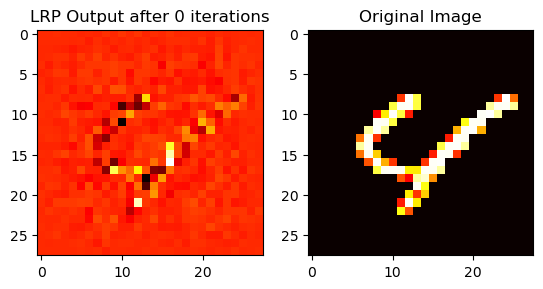

Epoch: 0, Test Classification Loss: 0.03372187726199627, Accuracy: 13.90625
Epoch: 0, Training Loss: 0.000349502436319987
Epoch: 1, Test Classification Loss: 0.032278867438435555, Accuracy: 10.78125
Epoch: 1, Training Loss: 0.00034160833358764647
Epoch: 2, Test Classification Loss: 0.031313106417655945, Accuracy: 19.84375
Epoch: 2, Training Loss: 0.0003295989274978638
Epoch: 3, Test Classification Loss: 0.02953039053827524, Accuracy: 35.9375
Epoch: 3, Training Loss: 0.000296496719121933
Epoch: 4, Test Classification Loss: 0.0247551953420043, Accuracy: 47.34375
Epoch: 4, Training Loss: 0.00025163556734720865


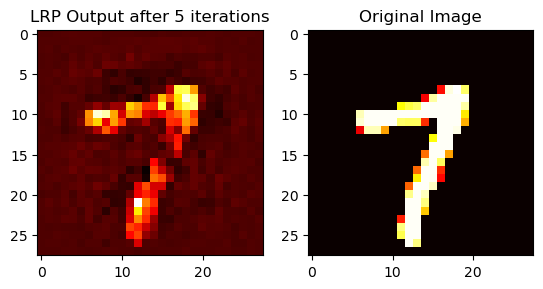

Epoch: 5, Test Classification Loss: 0.023470567353069783, Accuracy: 48.90625
Epoch: 5, Training Loss: 0.00022910687526067099
Epoch: 6, Test Classification Loss: 0.02066525015980005, Accuracy: 60.0
Epoch: 6, Training Loss: 0.00018049330015977225
Epoch: 7, Test Classification Loss: 0.018786105327308178, Accuracy: 62.5
Epoch: 7, Training Loss: 0.0001920557975769043
Epoch: 8, Test Classification Loss: 0.017418802436441182, Accuracy: 65.3125
Epoch: 8, Training Loss: 0.0001727140337228775
Epoch: 9, Test Classification Loss: 0.016506905294954778, Accuracy: 66.875
Epoch: 9, Training Loss: 0.00017647695938746136


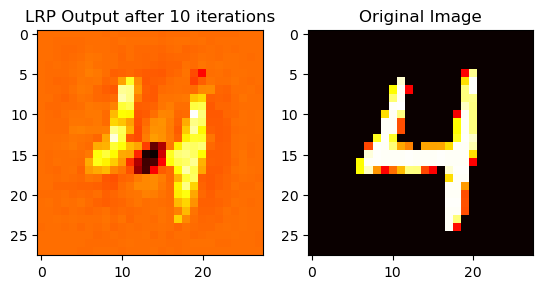

Epoch: 10, Test Classification Loss: 0.016444039717316627, Accuracy: 65.625
Epoch: 10, Training Loss: 0.00016386078198750813
Epoch: 11, Test Classification Loss: 0.013605531677603722, Accuracy: 72.8125
Epoch: 11, Training Loss: 0.00013882637321949005
Epoch: 12, Test Classification Loss: 0.013623717054724694, Accuracy: 73.75
Epoch: 12, Training Loss: 0.0001487659384806951
Epoch: 13, Test Classification Loss: 0.01231238730251789, Accuracy: 75.78125
Epoch: 13, Training Loss: 0.00013404385050137837
Epoch: 14, Test Classification Loss: 0.012500482611358166, Accuracy: 74.84375
Epoch: 14, Training Loss: 0.0001387885053952535


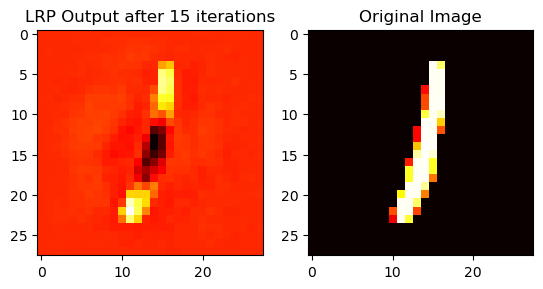

Epoch: 15, Test Classification Loss: 0.0133758376352489, Accuracy: 72.8125
Epoch: 15, Training Loss: 0.000133306551973025
Epoch: 16, Test Classification Loss: 0.012709126435220241, Accuracy: 74.6875
Epoch: 16, Training Loss: 0.0001288156529267629
Epoch: 17, Test Classification Loss: 0.012748399004340171, Accuracy: 73.75
Epoch: 17, Training Loss: 0.00013165687521298728
Epoch: 18, Test Classification Loss: 0.011656734067946673, Accuracy: 77.1875
Epoch: 18, Training Loss: 0.00012945391535758972
Epoch: 19, Test Classification Loss: 0.011324838921427726, Accuracy: 77.34375
Epoch: 19, Training Loss: 0.00012694266041119893


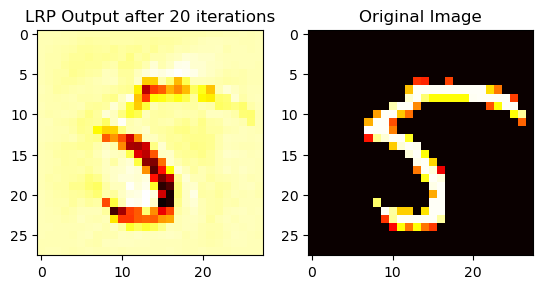

Epoch: 20, Test Classification Loss: 0.01256998609751463, Accuracy: 73.59375
Epoch: 20, Training Loss: 0.00013219221532344817
Epoch: 21, Test Classification Loss: 0.011955604795366526, Accuracy: 74.53125
Epoch: 21, Training Loss: 0.00013204617500305177
Epoch: 22, Test Classification Loss: 0.011588363070040941, Accuracy: 76.5625
Epoch: 22, Training Loss: 0.00012878167033195497
Epoch: 23, Test Classification Loss: 0.012220683880150318, Accuracy: 74.21875
Epoch: 23, Training Loss: 0.00010929804841677348
Epoch: 24, Test Classification Loss: 0.011922149825841189, Accuracy: 74.6875
Epoch: 24, Training Loss: 0.00012575164933999378


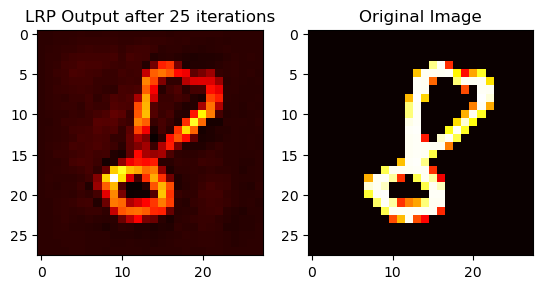

Epoch: 25, Test Classification Loss: 0.010100349131971598, Accuracy: 78.4375


In [9]:

# define device for GPU compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and transform datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the network and optimizer for the underlying network

# now wrap the network in the LRP class
model = WrapperNet(SimpleRNet(), hybrid_loss=True)
optimizer= optim.Adam(model.parameters(), lr=1e-4)

# define the loss functions for each
# lambda parameter weights cross entropy loss with CosineDistance. 
# The higher the lambda parameter, the more weight is given to the cosine distnace loss
criterion = HybridCosineDistanceCrossEntopyLoss(_lambda=0.1)
# Move to device
model.to(device)

EPOCHS = 100
VISUALIZE_FREQ = 5
for x in range(EPOCHS):
    if x % VISUALIZE_FREQ == 0:
        plot_heatmap_comparison(model, test_loader, device, apply_threshold, x)
    test_classification_loss, accuracy = test_model(model, criterion, test_loader, device, apply_threshold)
    print(f'Epoch: {x}, Test Classification Loss: {test_classification_loss}, Accuracy: {accuracy}')
    train_loss = train_model(model, optimizer, criterion, train_loader, device, apply_threshold)
    print(f'Epoch: {x}, Training Loss: {train_loss}')
    
